**Import required libraries**

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#nltk.download('all')

**Load Data**

In [20]:
school_comments = pd.read_csv('./Files/total_reviews.csv')
school_comments.head()

,University,Comment,Question
0,Stanford Graduate School of Business,There is no one job for HBS or GSB graduates. ...,What-are-the-typical-hours-and-salaries-of-the...
1,Stanford Graduate School of Business,Most well-paying jobs right out of business sc...,What-are-the-typical-hours-and-salaries-of-the...
2,Stanford Graduate School of Business,[1] I believe that you might find Poets and Q...,What-are-the-typical-hours-and-salaries-of-the...
3,Stanford Graduate School of Business,The salary info is available on the Harvard Bu...,What-are-the-typical-hours-and-salaries-of-the...
4,Stanford Graduate School of Business,Typical HBS grad would make 120 - 130K if he/s...,What-are-the-typical-hours-and-salaries-of-the...


**Data pre-processing**

In [4]:
# ## Set the stopwords
stop_words = set(stopwords.words('english'))

# ## Filter out all the meaningless words
unwanted_words = ["right","various","specific","real","mba", "lbs", "nyu", "duke", "iese", "hec", "insead", "esade", "ie", "columbia", "stanford", 
                  "wharton", "harvard", "oxford", "kellogg", "booth", "ross", "fuqua", "sda", "bocconi", "yale", "ucla", "utd", "uc", "michigan", 
                  "anderson", "haas", "mccombs","better","top","different","many","good","best","great","ut","usc","big","new","strong","high",
                  "first","american","emba","financial","important","higher","ivy","several","international","global","academic","much","personal",
                  "average","northwest","major","uk","excellent","able","general","second","wrong","indian","stern","similar","stronger","smaller",
                  "interested","european","northwestern","sure","due","u","hbs","overall","austin","full","misb","willing","certain","least","certain","likely"] 

# ## Find the top 5 adjective words for each school
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    filtered_tokens = [
        lemmatizer.lemmatize(word) for word, tag in pos_tag(tokens)
        if tag in ['JJ', 'JJR', 'JJS']
        and word not in stop_words
        and (word.isalpha() or word.isspace())
        and word not in unwanted_words  
    ]
    #filtered_tokens.extend([lemmatizer.lemmatize(w) for w in tokens if w not in stop_words])
    return filtered_tokens

**Find the nearest competitors for each university**

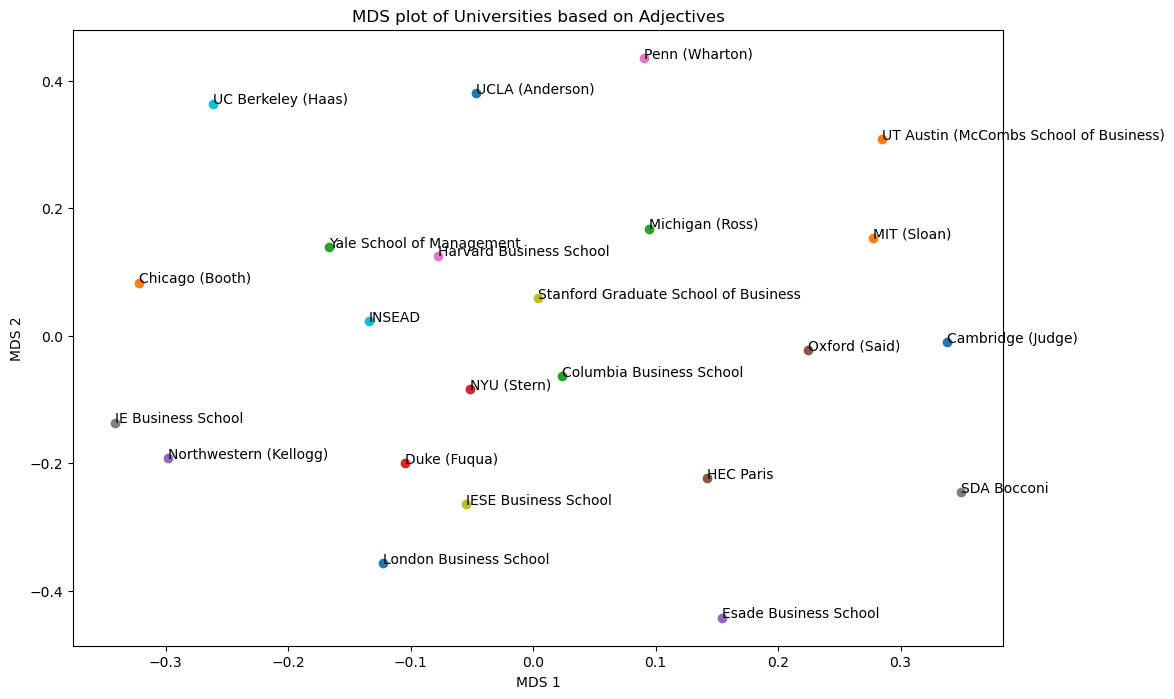

In [5]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# Convert the top adjectives to a matrix of dummy variables
dummy_matrix = pd.get_dummies(school_comments.groupby('University')['Comment'].apply(lambda x: ' '.join(x)).apply(preprocess_text).apply(pd.Series).stack()).groupby(level=0).sum()

# Calculate a similarity matrix
similarity_matrix = pairwise_distances(dummy_matrix, metric='cosine')

# Apply MDS
mds = MDS(n_components=2, random_state=1, dissimilarity='precomputed',normalized_stress=False)
projected_coords = mds.fit_transform(similarity_matrix)

# Plot the results
plt.figure(figsize=(12, 8))
for i, university in enumerate(dummy_matrix.index):
    plt.scatter(projected_coords[i, 0], projected_coords[i, 1], label=university)

    # label the points with university names for clarity
    plt.annotate(university, (projected_coords[i, 0], projected_coords[i, 1]))

plt.title('MDS plot of Universities based on Adjectives')
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
#plt.legend()
plt.show()

**Pre-process the data again**

In [7]:
lemmatizer = WordNetLemmatizer()

unwanted_words = ["india","asia","right","real","mba", "lbs", "nyu", "duke", "iese", "hec", "insead", "esade", "ie", "columbia", "stanford", 
                  "wharton", "harvard", "oxford", "kellogg", "booth", "ross", "fuqua", "sda", "bocconi", "yale", "ucla", "utd", "uc", "michigan", 
                  "anderson", "haas", "mccombs","better","different","many","good","ut","usc","big","new","first","american","emba","higher",
                  "several","international","global","academic","much","personal","average","northwest","major","uk","able","general","second",
                  "wrong","stern","similar","stronger","smaller","interested","european","northwestern","sure","due","u","hbs","overall","austin",
                  "full","misb","willing","least","certain","likely","gsb","school","year"] 

def preprocess_text2(doc):
    # Remove stopwords, special characters, and lemmatize the words
    tokens = word_tokenize(doc.lower())
    return [
        lemmatizer.lemmatize(word) for word, tag in pos_tag(tokens)
        if tag in ['JJ', 'JJR', 'JJS',"NN","NNS","NNP","NNPS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ"]
        and word not in stop_words
        and (word.isalnum() or word.isspace())
        and word not in unwanted_words 
    ]

school_comments['cleaned'] = school_comments['Comment'].apply(preprocess_text2)

**Perform topic modelling for each university**

In [8]:
# Create a dictionary and corpus required for Topic Modeling
topics ={}
topic_df = {}
school_comments["Topic"] = -1
final_df = pd.DataFrame(columns=school_comments.columns)
def get_document_topics(doc_bow):
    # Get the topic probabilities for the document
    topic_probs = lda_model.get_document_topics(doc_bow)
    # Get the topic with the highest probability
    main_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0]
    return main_topic[0]  # return the topic id

# Assign the topics to each document
for uni in school_comments["University"].unique().tolist():
    df = school_comments[school_comments["University"]==uni]
    dictionary = corpora.Dictionary(df['cleaned'])
    corpus = [dictionary.doc2bow(text) for text in df['cleaned']]

    # Number of topics you wish to extract
    num_topics = 10

    # Build the LDA model
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    topics.update({uni:lda_model})
    top = lda_model.print_topics()
    df["Topic"] = df['cleaned'].apply(lambda row: get_document_topics(dictionary.doc2bow(row)))
    final_df = pd.concat([final_df,df],ignore_index=True)

final_df_comments = final_df.copy()

In [22]:
#Write the university and topics lexical keys in a csv file

topic_df = {}
for uni,mods in topics.items():
    topic_df.update({uni:mods.print_topics()})
df = pd.DataFrame(topic_df.items(),columns=["Key","Value"]).explode("Value")
df.to_csv("./Files/Topic_modelling.csv",index=False)
df.head()

,Key,Value
0,Stanford Graduate School of Business,"(0, 0.018*""experience"" + 0.018*""skill"" + 0.015..."
0,Stanford Graduate School of Business,"(1, 0.082*""salary"" + 0.073*""cost"" + 0.049*""ben..."
0,Stanford Graduate School of Business,"(2, 0.019*""stand"" + 0.019*""fit"" + 0.017*""gmat""..."
0,Stanford Graduate School of Business,"(3, 0.032*""business"" + 0.023*""sloan"" + 0.018*""..."
0,Stanford Graduate School of Business,"(4, 0.039*""people"" + 0.022*""management"" + 0.02..."


After this, you will need to manually give some sensible names to the topics we just found based upon their lexical footprints

**Sentiment Analysis for each college's review**

In [10]:
sid = SentimentIntensityAnalyzer()
def analyze_sentiment_vader(text):
    # Sentiment analysis
    return sid.polarity_scores(text)["compound"]

final_df['sentiment_vader'] = final_df['Comment'].apply(analyze_sentiment_vader)

In [11]:
def get_sentiment_direction(sent):
    if sent>=0.005:
        return "Positive"
    elif sent >-0.05 and sent <0.005:
        return "Neutral"
    else:
        return "Negative"

final_df["sentiment_category"] =  final_df["sentiment_vader"].apply(get_sentiment_direction)

**Get the top 5 topics discussed positively in context of UT Austin**

In [12]:
conv_df = final_df.groupby(["University","Topic","sentiment_category"]).size().reset_index(name="Count").sort_values(by=["University","Count"],ascending=False)
conv_df[(conv_df["University"]=="UT Austin (McCombs School of Business)")].head()

,University,Topic,sentiment_category,Count
387,UT Austin (McCombs School of Business),7,Positive,49
384,UT Austin (McCombs School of Business),5,Positive,47
379,UT Austin (McCombs School of Business),3,Positive,30
374,UT Austin (McCombs School of Business),1,Positive,28
390,UT Austin (McCombs School of Business),9,Positive,24


I examined the most talked-about topics for four MBA programs ranked near McCombs (17th) by QS: Yale (10th), NYU Stern (11th), Michigan Ross (12th), and Duke Fuqua (13th). By creating a matrix of these hot topics (shown below), it is noticable that the conversations surrounding McCombs differ from those at each of its close competitors. Note these topic names were decided by me after judging the lexical footprint we got in the previous step.

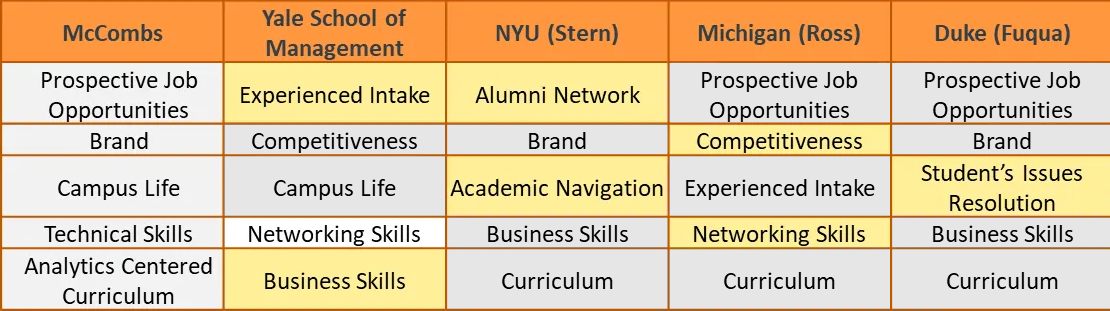

**Topic modelling irrespecive of the university**

In [13]:
dictionary = corpora.Dictionary(school_comments['cleaned'])
corpus = [dictionary.doc2bow(text) for text in school_comments['cleaned']]

# Number of topics you wish to extract
num_topics = 10

# Build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

school_comments["Topic"] = school_comments['cleaned'].apply(lambda row: get_document_topics(dictionary.doc2bow(row)))
school_comments['sentiment_vader'] = school_comments['Comment'].apply(analyze_sentiment_vader)
school_comments["sentiment_category"] =  school_comments["sentiment_vader"].apply(get_sentiment_direction)

To get a broader perspective, I applied the same sentiment analysis and topic modeling approach across the top 20 MBA programs, without focusing on any specific university. I then compared these universal values with the specific strengths attributed to McCombs, offering a comprehensive view of how McCombs stands in relation to general expectations from top MBA colleges.

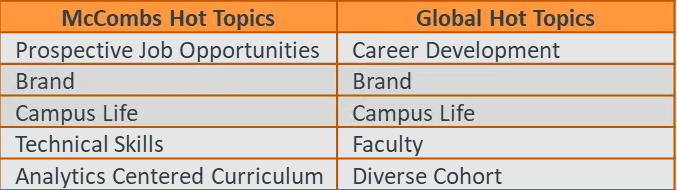


In [21]:
#Write the topics lexical keys in a csv file

all_mods ={}
for k,v in enumerate(lda_model.print_topics()):
    all_mods.update({k:v[1]})

all_mods_df = pd.DataFrame(all_mods.items(),columns=["Key","Value"])
all_mods_df.to_csv("./Files/All_topics.csv",index=False)
all_mods_df.head()

,Key,Value
0,0,"0.020*""experience"" + 0.020*""work"" + 0.015*""get..."
1,1,"0.044*""programme"" + 0.032*""function"" + 0.022*""..."
2,2,"0.045*""people"" + 0.029*""think"" + 0.025*""compan..."
3,3,"0.024*""chain"" + 0.016*""http"" + 0.013*""year"" + ..."
4,4,"0.067*""management"" + 0.023*""operation"" + 0.020..."
